In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from math import sqrt
import plotly.graph_objects as go
import statsmodels.api as sm
import math
import plotly.express as px
import random
import re

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
df_netflix= pd.read_csv('/content/drive/MyDrive/netflix_titles.csv', usecols=['show_id','title','director','cast','listed_in','description'])
df_titles= pd.read_csv('/content/drive/MyDrive/titles.csv', usecols=['id','title','type','genres','imdb_votes','imdb_score','tmdb_popularity','tmdb_score'])
df_credits= pd.read_csv('/content/drive/MyDrive/credits.csv')
df_imdb= pd.read_csv('/content/drive/MyDrive/imdb_top_1000.csv', usecols=['Series_Title', 'Gross'])

In [61]:
df_netflix['title'] = df_netflix['title'].str.lower().str.strip()
df_titles['title'] = df_titles['title'].str.lower().str.strip()
df_imdb['Series_Title']= df_imdb['Series_Title'].str.lower().str.strip()
df_imdb['Gross']= df_imdb['Gross'].str.lower().str.strip()

In [62]:
def clean_title(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    else:
        return text

df_netflix['title'] = df_netflix['title'].apply(clean_title)
df_titles['title'] = df_titles['title'].apply(clean_title)
df_imdb['Series_Title'] = df_imdb['Series_Title'].apply(clean_title)


In [64]:
def remove_suffix(title):
    if isinstance(title, str):  # Checking if the input is a string
        if title.endswith('the movie'):
            return title[:-9].strip()
    return title

# Applying the remove_suffix function to the 'title' column of each DataFrame
df_netflix['title'] = df_netflix['title'].apply(remove_suffix)
df_titles['title'] = df_titles['title'].apply(remove_suffix)
df_imdb['Series_Title'] = df_imdb['Series_Title'].apply(remove_suffix)


In [65]:
merged_df = pd.merge(df_titles, df_credits, on='id', how='inner')
remerged_df = pd.merge(merged_df, df_netflix, on='title', how='inner')
reremerged_df = pd.merge(remerged_df, df_imdb[['Series_Title', 'Gross']], left_on='title', right_on='Series_Title', how='inner')

In [68]:
print(reremerged_df[['title', 'Series_Title']].sample(5))

                    title         Series_Title
1819                 roma                 roma
1448                 rush                 rush
1472         nightcrawler         nightcrawler
598   catch me if you can  catch me if you can
2049         the irishman         the irishman


In [67]:
mismatches = reremerged_df[reremerged_df['title'] != reremerged_df['Series_Title']]
print(f"Number of mismatches: {len(mismatches)}")

if len(mismatches) > 0:
    print("Here are some mismatches:")
    print(mismatches[['title', 'Series_Title']].head())

Number of mismatches: 0


In [69]:
reremerged_df.drop('Series_Title', axis=1, inplace=True)

In [29]:
reremerged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2479 non-null   object 
 1   title            2479 non-null   object 
 2   type             2479 non-null   object 
 3   genres           2479 non-null   object 
 4   imdb_score       2384 non-null   float64
 5   imdb_votes       2384 non-null   float64
 6   tmdb_popularity  2479 non-null   float64
 7   tmdb_score       2479 non-null   float64
 8   person_id        2479 non-null   int64  
 9   name             2479 non-null   object 
 10  character        2368 non-null   object 
 11  role             2479 non-null   object 
 12  show_id          2479 non-null   object 
 13  director         2443 non-null   object 
 14  cast             2479 non-null   object 
 15  listed_in        2479 non-null   object 
 16  description      2479 non-null   object 
 17  Gross         

In [70]:
reremerged_df.describe()

,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id
count,2384.000000,2.384000e+03,2479.000000,2479.000000,2.479000e+03
mean,7.785738,4.760895e+05,31.094015,7.583423,3.849510e+05
std,0.797056,4.926980e+05,23.570397,0.670965,5.460216e+05
min,3.100000,3.200000e+01,0.849000,3.700000,2.190000e+02
25%,7.700000,9.964700e+04,15.070000,7.400000,1.387500e+04
50%,7.900000,3.038680e+05,22.225000,7.600000,8.072400e+04
75%,8.200000,6.496760e+05,42.131000,8.000000,6.600315e+05
max,8.800000,2.294231e+06,134.700000,8.463000,2.435238e+06


In [71]:
print(reremerged_df.isnull().sum())

id                   0
title                0
type                 0
genres               0
imdb_score          95
imdb_votes          95
tmdb_popularity      0
tmdb_score           0
person_id            0
name                 0
character          111
role                 0
show_id              0
director            36
cast                 0
listed_in            0
description          0
Gross              287
dtype: int64


In [72]:
reremerged_df.columns = reremerged_df.columns.str.title()

In [73]:
reremerged_df['Imdb_Score'].fillna(reremerged_df['Imdb_Score'].mean(), inplace=True)

reremerged_df['Imdb_Votes'].fillna(reremerged_df['Imdb_Votes'].median(), inplace=True)

reremerged_df['Tmdb_Score'].fillna(reremerged_df['Tmdb_Score'].mean(), inplace=True)

reremerged_df['Director'].fillna('Unknown', inplace=True)

reremerged_df['Character'].fillna('Unknown', inplace=True)

most_common_cast = reremerged_df['Cast'].mode()[0]
reremerged_df['Cast'].fillna(most_common_cast, inplace=True)

# Removing commas
reremerged_df['Gross'] = reremerged_df['Gross'].replace(',', '', regex=True)

# Conversion process
reremerged_df['Gross'] = reremerged_df['Gross'].astype(float)

# Comma separated values can now be treated as decimals when calculating median
gross_median = reremerged_df['Gross'].median()
reremerged_df['Gross'].fillna(gross_median, inplace=True)

In [74]:
print(reremerged_df.isnull().sum())

Id                 0
Title              0
Type               0
Genres             0
Imdb_Score         0
Imdb_Votes         0
Tmdb_Popularity    0
Tmdb_Score         0
Person_Id          0
Name               0
Character          0
Role               0
Show_Id            0
Director           0
Cast               0
Listed_In          0
Description        0
Gross              0
dtype: int64


In [75]:
duplicate_rows = reremerged_df.duplicated().sum()

print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [76]:
reremerged_df

,Id,Title,Type,Genres,Imdb_Score,Imdb_Votes,Tmdb_Popularity,Tmdb_Score,Person_Id,Name,Character,Role,Show_Id,Director,Cast,Listed_In,Description,Gross
0,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,3748,Robert De Niro,Travis Bickle,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
1,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,14658,Jodie Foster,Iris Steensma,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
2,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,7064,Albert Brooks,Tom,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
3,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,3739,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
4,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,48933,Cybill Shepherd,Betsy,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,66872,Manoj Bajpayee,Musafir Ali,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0
2475,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,67162,Kay Kay Menon,Indrashish Shah,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0
2476,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,235529,Harshvardhan Kapoor,Vik,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0
2477,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,940893,Radhika Madan,Didi,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0


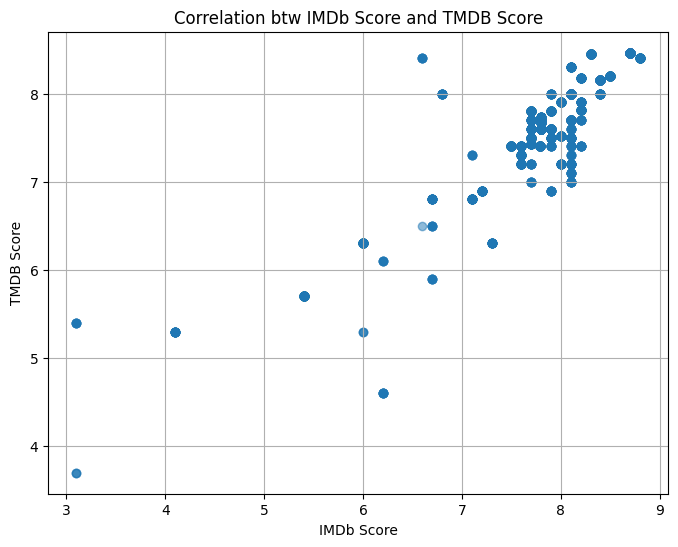

In [77]:
plt.figure(figsize=(8, 6))
plt.scatter(reremerged_df['Imdb_Score'], reremerged_df['Tmdb_Score'], alpha=0.5)
plt.title('Correlation btw IMDb Score and TMDB Score')
plt.xlabel('IMDb Score')
plt.ylabel('TMDB Score')
plt.grid(True)
plt.show()

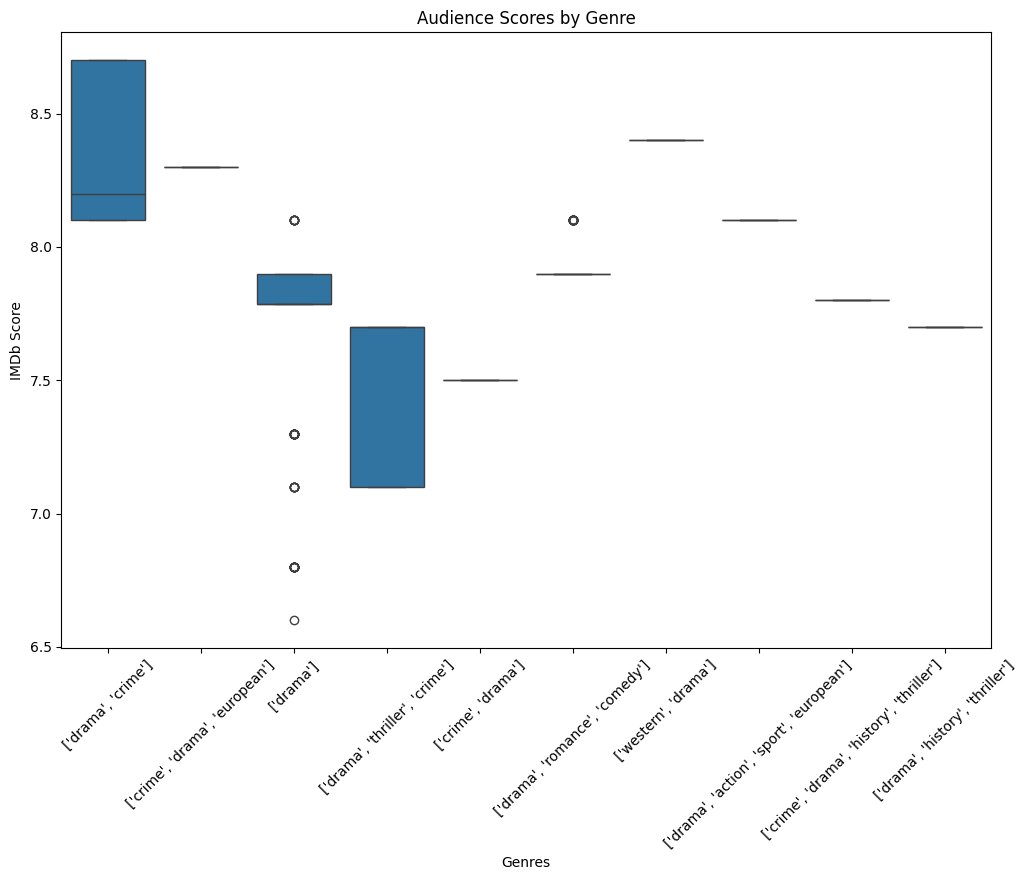

In [78]:
top_genres = reremerged_df['Genres'].value_counts().head(10).index

filtered_df = reremerged_df[reremerged_df['Genres'].isin(top_genres)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='Genres', y='Imdb_Score', data=filtered_df)
plt.title('Audience Scores by Genre')
plt.xlabel('Genres')
plt.ylabel('IMDb Score')
plt.xticks(rotation=45)
plt.show()

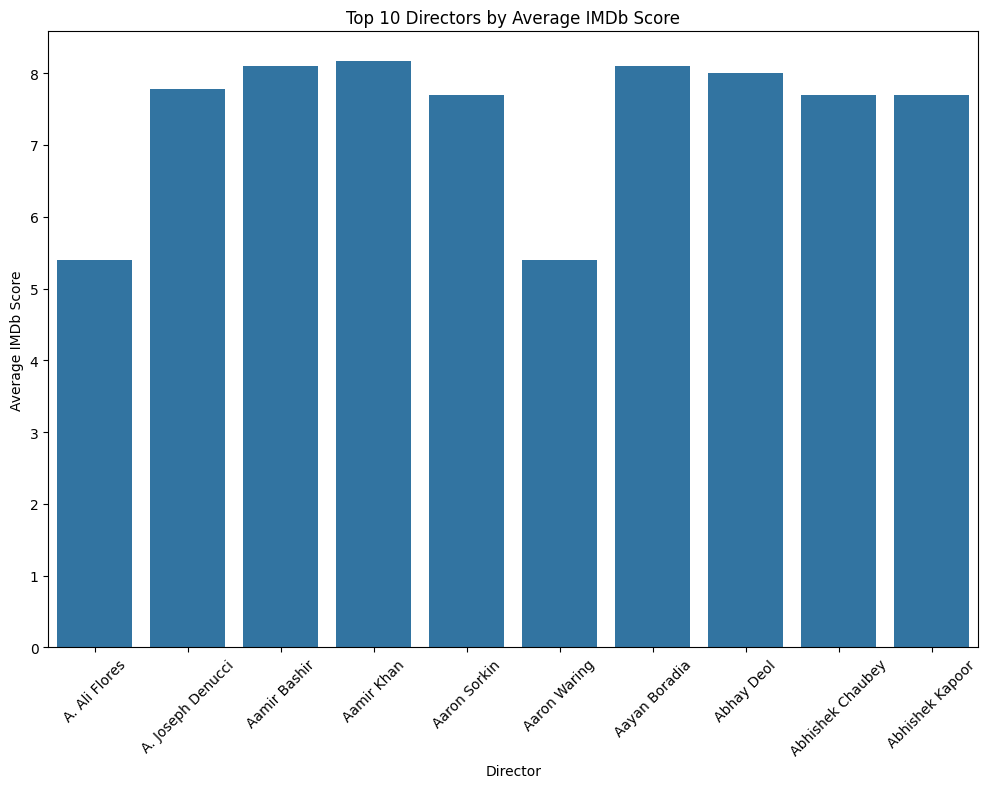

In [79]:
director_avg_imdb_scores = reremerged_df.groupby('Name')['Imdb_Score'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Name', y='Imdb_Score', data=director_avg_imdb_scores.head(10))
plt.title('Top 10 Directors by Average IMDb Score')
plt.xlabel('Director')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

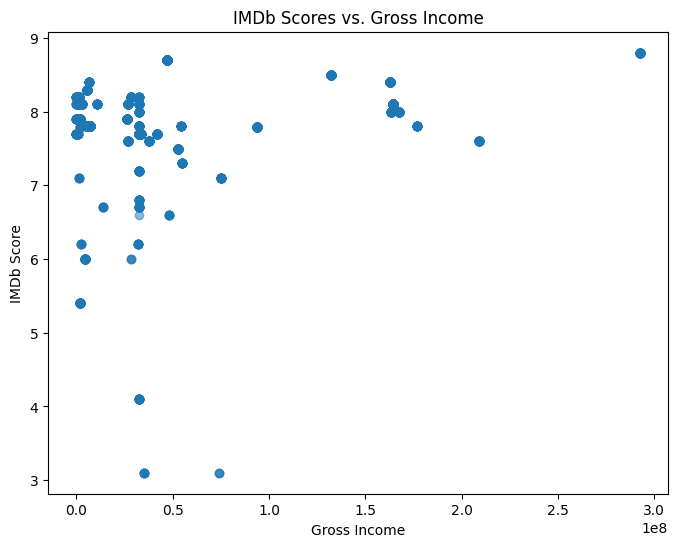

In [80]:
plt.figure(figsize=(8, 6))
plt.scatter(reremerged_df['Gross'], reremerged_df['Imdb_Score'], alpha=0.5)
plt.title('IMDb Scores vs. Gross Income')
plt.xlabel('Gross Income')
plt.ylabel('IMDb Score')
plt.show()